In [87]:
import warnings
import sys 
import os    
from statesegmentation import GSBS
from functools import reduce
import numpy as np
from brainiak.eventseg.event import EventSegment
import nibabel as nib
from nilearn.masking import apply_mask, compute_epi_mask
from scipy.stats import zscore

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
%matplotlib inline

def plot_tt_similarity_matrix(ax, data_matrix, bounds, n_TRs, title_text):
    
    ax.imshow(np.corrcoef(data_matrix), cmap = 'viridis')
    ax.set_title(title_text)
    ax.set_xlabel('TR')
    ax.set_ylabel('TR')
    
    # plot the boundaries 
    bounds_aug = np.concatenate(([0], bounds, [n_TRs]))
    
    for i in range(len(bounds_aug) - 1):
        rect = patches.Rectangle(
            (bounds_aug[i], bounds_aug[i]),
            bounds_aug[i+1] - bounds_aug[i],
            bounds_aug[i+1] - bounds_aug[i],
            linewidth = 2, edgecolor = 'w',facecolor = 'none'
        )
        ax.add_patch(rect)
        
def tr_tr_plot(pred_seg, data, num_time_points, gsbs = 0):
    
    # extract the boundaries 
    bounds = (
        np.where(np.diff(np.argmax(pred_seg, axis = 1)))[0]
        if gsbs == 0
        else np.where(np.diff(pred_seg.bounds))[0]
    )

    f, ax = plt.subplots(1,1, figsize = (10,8))
    title_text = '''
    Overlay the predicted event boundaries
    on top of the TR-TR correlation matrix
    '''
    plot_tt_similarity_matrix(ax, data, bounds, num_time_points, title_text)
    f.tight_layout()

## 0. Load Angular Gyrus data

From the angular gyrus (area PG from (Eickhoff et al., 2005), we'll load movie data from all subjects, and recall data from one subject. Subjects were watching the first hour of [A Study in Pink](https://en.wikipedia.org/wiki/A_Study_in_Pink) (here we are loading only the first half of this data), and then freely recalled the narrative. Please refer to [Chen et al. (2017)](https://doi.org/10.1038/nn.4450) to learn more about this dataset. 

In [2]:
%%time

Sherlock_path = '../../Sherlock/'
movie = []

for sub in range(1,17):
    print('Loading sub-%02d' % sub)
    movie.append(apply_mask(os.path.join(Sherlock_path, 'fmriprep','sub-%02d' % sub, 'func', \
                           'sub-%02d_denoise_smooth6mm_task-sherlockPart1_AngOnly_bold.nii.gz' % sub),
                           os.path.join(Sherlock_path, 'AG_mask.nii.gz')))
    if sub == 7:
        recall = apply_mask(os.path.join(Sherlock_path, 'fmriprep','sub-%02d' % sub, 'func', \
                           'sub-%02d_denoise_smooth6mm_task-freerecall_AngOnly_bold.nii.gz' % sub),
                           os.path.join(Sherlock_path, 'AG_mask.nii.gz'))

valid_vox = reduce(np.union1d, [np.where(np.std(m, axis=0)>0)[0] for m in movie])
movie = [m[:,valid_vox] for m in movie]
movie_group = np.mean(movie, axis=0)

Loading sub-01
Loading sub-02
Loading sub-03
Loading sub-04
Loading sub-05
Loading sub-06
Loading sub-07
Loading sub-08
Loading sub-09
Loading sub-10
Loading sub-11
Loading sub-12
Loading sub-13
Loading sub-14
Loading sub-15
Loading sub-16
CPU times: user 10min 37s, sys: 1min 30s, total: 12min 8s
Wall time: 12min 8s


## 1. Finding event boundaries during perception

### 1.0 Event structure in activity patterns

Before applying any model, a good first step is to plot the correlation between activity patterns for each pair of timepoints during the movie. In this dataset, this shows blocks along the diagonal, which indicates that activity patterns are remaining stable for periods of tens of timepoints. This is the kind of structure that the HMM and GBSS models will be looking for.

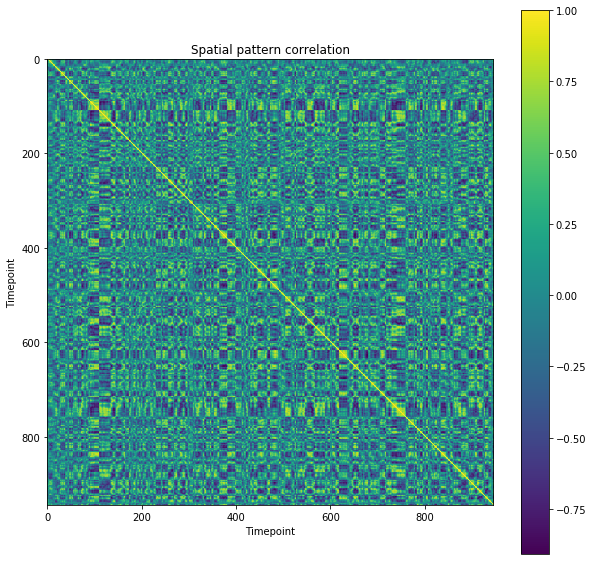

In [3]:
plt.figure(figsize=(10,10))
plt.imshow(np.corrcoef(movie_group))
plt.xlabel('Timepoint')
plt.ylabel('Timepoint')
plt.colorbar()
plt.title('Spatial pattern correlation');

### 1.1 Fitting the HMM

To use an HMM to find both the event timings and the patterns corresponding to each event, we can use the EventSegment class from the brainiak toolbox. We need to specify the number of events, which here we set to 29 (corresponding to the number of boundaries typically annotated by human subjects). This fit produces:
* A matrix showing the probability of being in each event at each timepoint
* The mean pattern for each event
* The log-likelihood (measuring overall model fit)

In [4]:
movie_HMM = EventSegment(n_events = 29)
movie_HMM.fit(movie_group)

# TO-DO: plot/print the three outputs described above
#        Can show boundaries on timepoint correlation matrix
#        Re-run with split-merge

EventSegment(event_chains=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
             n_events=29, n_iter=500, split_merge=False,
             split_merge_proposals=1,
             step_var=<function EventSegment._default_var_schedule at 0x7f2e7c6ae440>)

In [5]:
# A matrix showing the probability of being in each event at each timepoint

print(movie_HMM.segments_[0])

[[1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99999962e-01 3.81305999e-08 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99999925e-01 7.46054782e-08 1.14727993e-16 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 5.14774229e-16
  4.92158298e-06 9.99995078e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  3.02127343e-06 9.99996979e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]


In [6]:
# The mean pattern for each event

print(movie_HMM.segments_[0].mean(axis = 0))

[0.04026401 0.04924562 0.02766636 0.02575469 0.03949764 0.02384529
 0.03690831 0.02707678 0.01178527 0.04302343 0.05864759 0.02073443
 0.04361021 0.02244057 0.05315958 0.01655659 0.03476771 0.07777133
 0.02389531 0.02076705 0.06260951 0.02035375 0.02205361 0.04181228
 0.03874417 0.0267333  0.03406221 0.03372382 0.02248956]


Text(0.5, 0, 'EM steps')

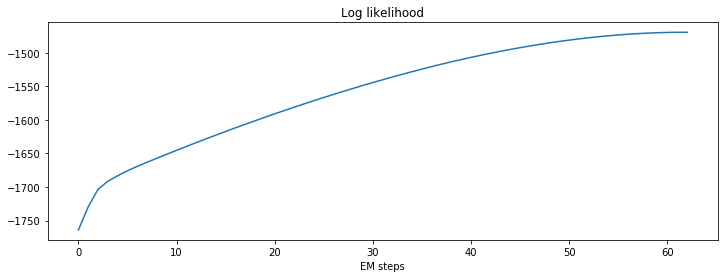

In [7]:
# The log-likelihood (measuring overall model fit)
 
f, ax = plt.subplots(1,1, figsize = (12, 4))
ax.plot(movie_HMM.ll_)
ax.set_title('Log likelihood')
ax.set_xlabel('EM steps')

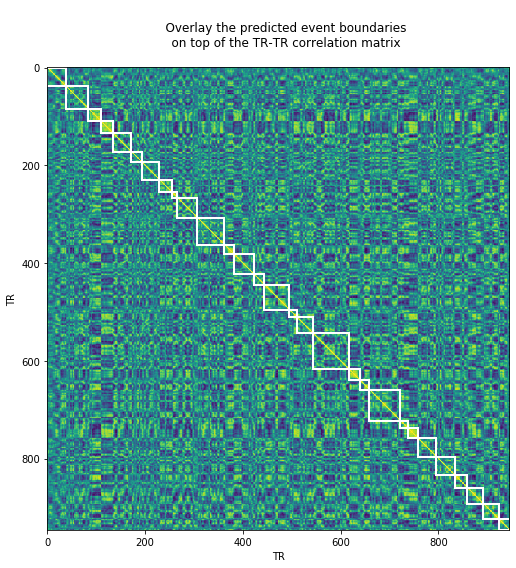

In [8]:
# Boundaries on timepoint correlation matrix
   
tr_tr_plot(movie_HMM.segments_[0], movie_group, movie_group.shape[0])

In [9]:
# Split Merge

movie_HMM_split_merge = EventSegment(n_events = 29, split_merge = True)
movie_HMM_split_merge.fit(movie_group)

EventSegment(event_chains=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
             n_events=29, n_iter=500, split_merge=True, split_merge_proposals=1,
             step_var=<function EventSegment._default_var_schedule at 0x7f2e7c6ae440>)

In [10]:
# A matrix showing the probability of being in each event at each timepoint

print(movie_HMM_split_merge.segments_[0])

[[1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99999995e-01 5.21116131e-09 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99999990e-01 1.00806750e-08 4.14185646e-12 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.95777685e-09
  8.82450264e-03 9.91175492e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.98078356e-03 9.98019216e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]


In [11]:
# The mean pattern for each event

print(movie_HMM_split_merge.segments_[0].mean(axis = 0))

[0.04074284 0.01945484 0.03037693 0.02660538 0.02575009 0.03951749
 0.0238041  0.03689816 0.02551299 0.05608722 0.03265048 0.0271585
 0.01942363 0.01742387 0.02896214 0.07351496 0.05167096 0.0772772
 0.0238055  0.02089933 0.0743264  0.03057128 0.0421948  0.0633911
 0.01851732 0.01736211 0.03350416 0.01371707 0.00887916]


Text(0.5, 0, 'EM steps')

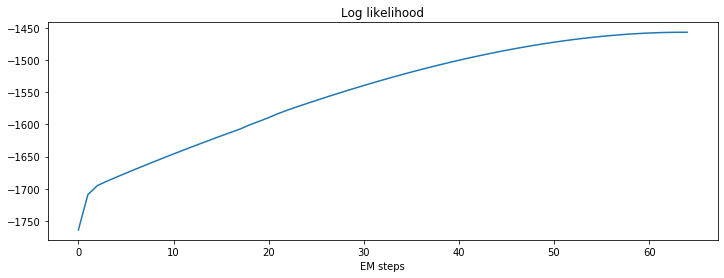

In [12]:
# The log-likelihood (measuring overall model fit)
 
f, ax = plt.subplots(1,1, figsize = (12, 4))
ax.plot(movie_HMM_split_merge.ll_)
ax.set_title('Log likelihood')
ax.set_xlabel('EM steps')

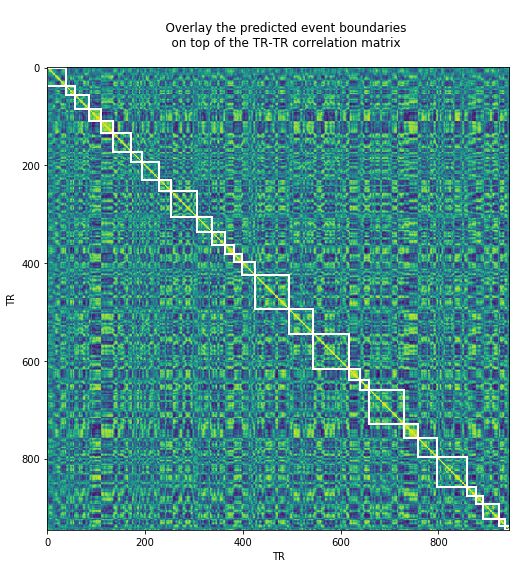

In [13]:
# Boundaries on timepoint correlation matrix

tr_tr_plot(movie_HMM_split_merge.segments_[0], movie_group, movie_group.shape[0])

### 1.2 Determining the number of events with the HMM

One way to determine the best number of events is to fit the model on a training set and then test the model fit on independent subjects.

(In this example, the training and test sets are the same size, so their variances should be similar. If the test set is smaller than the training set, you should pass a different variance value to find_events(). For example, calc_weighted_event_var() can be used to estimate the variance within a matched-sized subset of the training set.)

In [14]:
%%time

#TO-DO - figure out good k range and step size to run in reasonable time
#        try with split_merge

k_array = np.arange(5, 51, 5)
test_ll = np.zeros(len(k_array))

for i, k in enumerate(k_array):
    print('Testing %d events...' % k)
    movie_train = np.mean(movie[:8], axis = 0)
    movie_HMM = EventSegment(k)
    movie_HMM.fit(movie_train)
    
    movie_test = np.mean(movie[8:], axis = 0)
    _, test_ll[i] = movie_HMM.find_events(movie_test)

Testing 5 events...
Testing 10 events...
Testing 15 events...
Testing 20 events...
Testing 25 events...
Testing 30 events...
Testing 35 events...
Testing 40 events...
Testing 45 events...
Testing 50 events...
CPU times: user 13min 1s, sys: 21min 14s, total: 34min 16s
Wall time: 14min 35s


In [15]:
%%time

k_array = np.arange(5, 51, 5)
test_ll = np.zeros(len(k_array))

for i, k in enumerate(k_array):
    print('Testing %d events...' % k)
    movie_train = np.mean(movie[:8], axis = 0)
    movie_HMM_split_merge = EventSegment(k, split_merge = True)
    movie_HMM_split_merge.fit(movie_train)
    
    movie_test = np.mean(movie[8:], axis = 0)
    _, test_ll[i] = movie_HMM_split_merge.find_events(movie_test)

Testing 5 events...
Testing 10 events...
Testing 15 events...
Testing 20 events...
Testing 25 events...
Testing 30 events...
Testing 35 events...
Testing 40 events...
Testing 45 events...
Testing 50 events...
CPU times: user 25min 49s, sys: 43min 51s, total: 1h 9min 40s
Wall time: 27min 44s


### 1.3 Finding event boundaries with GSBS

In [16]:
%%time

states = GSBS(x = movie_group, kmax = 5) #100
states.fit()

# TO-DO: plot GSBS boundaries on timepoint correlation matrix
#        Compare to HMM boundaries?

CPU times: user 4min 9s, sys: 1min 8s, total: 5min 17s
Wall time: 5min 16s


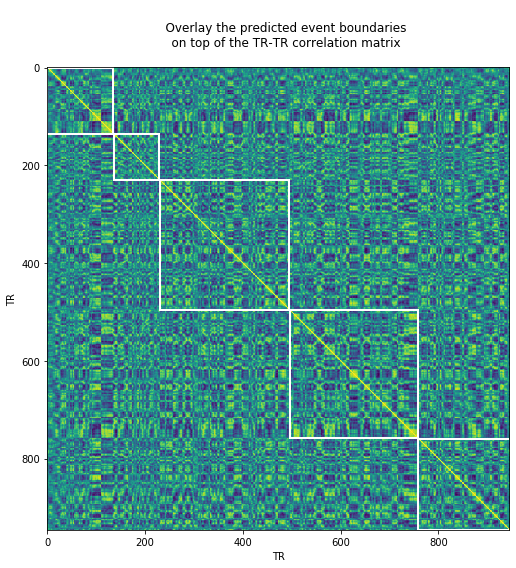

In [85]:
# plot GSBS boundaries on timepoint correlation matrix

tr_tr_plot(states, movie_group, movie_group.shape[0], gsbs = 1)

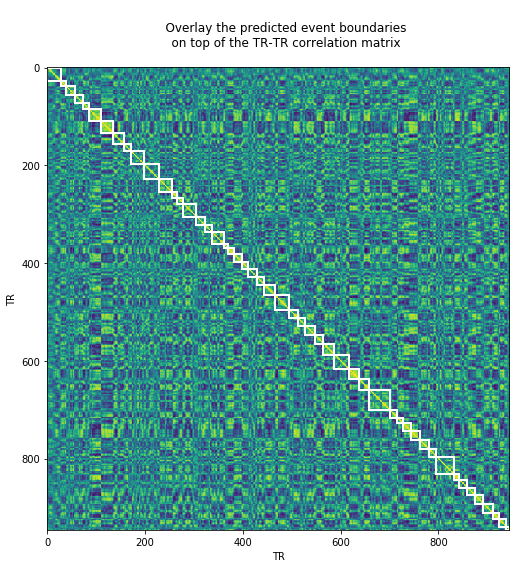

In [88]:
# Compare to HMM boundaries?

tr_tr_plot(movie_HMM_split_merge.segments_[0], movie_group, movie_group.shape[0])

## 2. Comparing model boundaries to human-labeled boundaries  <a id="model_to_human"></a>

We can also compare the event boundaries from a model to human-labeled event boundaries. Because there is some ambiguity in both the stimulus and the model about exactly which timepoint the transition occurs at, we will count two boundaries as being a "match" if they are within 3 TRs (4.5 seconds) of each other.

To determine whether the match is statistically significant, we generate permuted versions of the human boundaries as a null model for comparison.

In [18]:
human_bounds = [
    26, 35, 56, 72, 86, 108, 131, 143, 157, 173, 192, 204, 
    226, 313, 362, 398, 505, 526, 533, 568, 616, 634, 678,
    696, 747, 780, 870, 890
]

In [19]:
movie_HMM = EventSegment(n_events = 29, split_merge = True)
movie_HMM.fit(movie_group)
HMM_bounds = np.where(np.diff(np.argmax(movie_HMM.segments_[0], axis = 1)))[0]

In [20]:
# Define GSBS_bounds

movie_GSBS = GSBS(x = movie_group, kmax = 5)
movie_GSBS.fit()
GSBS_bounds = np.where(np.diff(movie_GSBS.bounds))[0]

In [73]:
def compare_bounds(model_bounds, human_bounds, num_TRs):
    np.random.seed(0)
    event_lengths = np.diff(np.concatenate(([0],human_bounds,[num_TRs])))
    nPerm = 10000
    human_bounds_perm = human_bounds.copy()
    threshold = 3

    match = np.zeros(nPerm + 1)
    for p in range(nPerm + 1):
        for hb in human_bounds_perm:
            if np.any(np.abs(model_bounds - hb) <= threshold):
                match[p] += 1
        match[p] /= len(human_bounds)
        human_bounds_perm = np.cumsum(np.random.permutation(event_lengths))[:-1]
    
    return match[0], (match[0] < match[1:]).mean()

num_TRs = movie_group.shape[0]
print('HMM match = %f, p = %f' % compare_bounds(HMM_bounds, human_bounds, num_TRs))
print('GSBS match = %f, p = %f' % compare_bounds(GSBS_bounds, human_bounds, num_TRs))

HMM match = 0.428571, p = 0.000300
GSBS match = 0.035714, p = 0.238900


## 3. Aligning movie and recall data

A simple model of free recall is that a subject will revisit the same sequence of events experienced during perception, but the lengths of the events will not be identical between perception and recall.

### 3.1. Fit HMM on the two datasets  simultaneously

We use the same fit function as for a single dataset, but now we pass in both the movie and recall datasets in a list. We assume the two datasets have shared event transitions.

In [89]:
movie_recall_HMM = EventSegment(29)
movie_recall_HMM.fit([movie_group, recall])

# TO-DO: Use hmm_ag_mvr.segments_[1] @ hmm_ag_mvr.segments_[0].T to show correspondence

AssertionError: 

In [25]:
#hmm_ag_mvr.segments_[1] @ hmm_ag_mvr.segments_[0].T
movie_recall_HMM.segments_[1]@movie_recall_HMM.segments_[0].T

NameError: name 'movie_recall_HMM' is not defined

### 3.2 Define events from movie, find in recall

In [ ]:
#TO-DO: Use GSBS to find movie events,
#       use set_event_patterns and calc_weighted_event_var to get patterns and variance,
#       use find_events to find events in recall

In [92]:
movie_GSBS = GSBS(x = movie_group, kmax = 5)
movie_GSBS.fit()

In [ ]:
state_transitions = np.where(np.diff(movie_GSBS.deltas))[0]
movie_HMM = EventSegment()
movie_HMM.set_event_patterns(EVENT_PAT) # event_pat: voxel by event ndarray
ev_var = movie_HMM.calc_weighted_event_var(movie_group, WEIGHTS, movie_HMM.event_pat_)
movie_HMM.find_events(recall, var = ev_var)